# Natalia Organek - ADZD -GraphX

## Task 1
Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków. (1 p.)
[This link](https://snap.stanford.edu/data/facebook-large-page-page-network.html)

In [1]:
import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.sql._
import org.apache.spark.rdd.RDD

Intitializing Scala interpreter ...

Spark Web UI available at http://56d4ddb4ffd4:4040
SparkContext available as 'sc' (version = 3.2.0, master = local[*], app id = local-1638992398636)
SparkSession available as 'spark'


import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.sql._
import org.apache.spark.rdd.RDD


In [14]:
import org.apache.spark.sql.functions._

import org.apache.spark.sql.functions._


In [7]:
val sc = (
    SparkContext
    .getOrCreate(
        new SparkConf()
        .setAppName("GraphX lab")
        .setMaster("local[*]")
    )
)

val vertices: RDD[(Long, (String, String))] = (
    sc.textFile("musae_facebook_target.csv")
    .map(line => {
        val x = line.split(",");
        (x(0).toLong, (x(2), x(3)))
    })
)

val edges: RDD[Edge[String]] = (
    sc.textFile("musae_facebook_edges.csv")
    .map(line => {
        val x = line.split(",");
        Edge(x(0).toLong, x(1).toLong, "")
    })
)

val default_node = ("", "")

val graph: Graph[(String, String), String] = Graph(vertices, edges, default_node)

sc: org.apache.spark.SparkContext = org.apache.spark.SparkContext@d5a52ca
vertices: org.apache.spark.rdd.RDD[(Long, (String, String))] = MapPartitionsRDD[29] at map at <console>:48
edges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[String]] = MapPartitionsRDD[32] at map at <console>:56
default_node: (String, String) = ("","")
graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@150039b9


In [8]:
graph.vertices.count()

res3: Long = 22470


In [9]:
graph.edges.count()

res4: Long = 171002


In [29]:
graph.triplets.collect

res14: Array[org.apache.spark.graphx.EdgeTriplet[(String, String),String]] = Array(((0,(The Voice of China 中国好声音,tvshow)),(18427,(The Voice Global,tvshow)),), ((1,(U.S. Consulate General Mumbai,government)),(2812,("U.S. Embassy Colombo, Sri Lanka")),), ((1,(U.S. Consulate General Mumbai,government)),(4987,(SportsUnited - U.S. Department of State,government)),), ((1,(U.S. Consulate General Mumbai,government)),(5228,(U.S. Embassy India,government)),), ((1,(U.S. Consulate General Mumbai,government)),(5307,(U.S. Mission Vienna,government)),), ((1,(U.S. Consulate General Mumbai,government)),(5755,(U.S. Embassy-Dhaka,government)),), ((1,(U.S. Consulate General Mumbai,government)),(6829,(U.S. Consulate General Karachi,government)),), ((1,(U.S. Consulate General Mumbai,government)),(7136,(USAID...


## Task 2
Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony politician oraz company też są spójne? (1 p.)

In [10]:
def isConnected(graph: Graph[(String, String), String]): Boolean = {
    graph.vertices.count() == graph.connectedComponents().vertices.count()
}

isConnected: (graph: org.apache.spark.graphx.Graph[(String, String),String])Boolean


In [11]:
println(isConnected(graph))

true


In [24]:
val politicians_graph = graph.subgraph(
    vpred={ case (f_id, (name, cat)) => cat == "politician"}
)

politicians_graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@3d776a09


In [25]:
println(isConnected(politicians_graph))

true


In [26]:
val companies_graph = graph.subgraph(
    vpred={ case (f_id, (name, cat)) => cat == "company"}
)

companies_graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@4046fe02


In [28]:
println(isConnected(companies_graph))

true


## Task 3
Spośród 1000 stron o najwyższym PageRank znaleźć 50 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 50 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot) (2 p.)

In [33]:
val ranks = graph.pageRank(0.0001).vertices

val rankDegreesNo = ranks.join(graph.degrees)

ranks: org.apache.spark.graphx.VertexRDD[Double] = VertexRDDImpl[3208] at RDD at VertexRDD.scala:57
rankDegreesNo: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, (Double, Int))] = MapPartitionsRDD[3217] at join at <console>:40


In [36]:
rankDegreesNo.takeSample(false, 3)

res20: Array[(org.apache.spark.graphx.VertexId, (Double, Int))] = Array((18136,(0.5867769331579539,1)), (17306,(0.8334493129950101,3)), (11119,(0.4092427032333338,9)))


In [41]:
val graphWithRankedDegrees = graph.outerJoinVertices(rankDegreesNo) 
{
    (id, page_data, vertexWithRank) => (
        page_data._1,  // page_name
        page_data._2,  // page_type
        vertexWithRank.getOrElse((0.0, 0))._1,  // PageRank value
        vertexWithRank.getOrElse((0.0, 0))._2   // degree
    )
}

graphWithRankedDegrees: org.apache.spark.graphx.Graph[(String, String, Double, Int),String] = org.apache.spark.graphx.impl.GraphImpl@68670338


In [39]:
graphWithRankedDegrees.vertices.takeSample(false, 3)

res22: Array[(org.apache.spark.graphx.VertexId, (String, String, Double, Int))] = Array((9638,(Baci Perugina,company,0.4065890958159526,1)), (13005,("Norbert Spinrath," MdB"",0.5298348945629537,21)), (10940,(Transavia,company,0.450447056659044,3)))


In [80]:
val ranked_1000 = (
    graphWithRankedDegrees
    .vertices.sortBy(_._2._3, ascending=false).take(1000)
)

ranked_1000: Array[(org.apache.spark.graphx.VertexId, (String, String, Double, Int))] = Array((21729,(The Obama White House,government,118.94062246225538,659)), (22208,(U.S. Department of State: Consular Affairs,government,67.13872903779196,205)), (21781,(Microsoft,company,56.441613845716724,14)), (22440,(City of Los Altos Police Department,government,55.24474131605187,43)), (22057,(The Connecticut National Guard,government,48.04856548640848,68)), (22438,(Federica Mogherini,politician,47.839737511075526,104)), (22329,(NHTSA,government,47.03110185658694,105)), (20415,(Joachim Herrmann,politician,42.78414021359476,320)), (22403,(Dr. Hedy Fry,politician,36.55870819775559,148)), (21955,(Digicel,company,36.209244761763706,83)), (19743,(The White House,government,34.638867699989376,678)), (22...


In [81]:
val tail_50 = (
    ranked_1000.sortBy(_._2._4).take(50)
)

tail_50: Array[(org.apache.spark.graphx.VertexId, (String, String, Double, Int))] = Array((21312,(New Balance Brasil,company,4.813144726586124,1)), (21726,(Kinder,company,6.035659502181131,2)), (22165,(adidas Women,company,5.148698067549846,2)), (21765,(財政部關務署高雄關,government,4.650875131715342,2)), (21884,("Australian High Commission," Malta"",4.598049278714286,2)), (14609,(spark7,company,6.3437837553842265,3)), (5563,(Viessmann,company,6.081924855755155,3)), (22260,(The Sopranos,tvshow,4.756389218533157,3)), (21125,(CT Style,tvshow,4.494935310239416,3)), (13880,("Bom dia Amazônia," Jornal do AC e G1 AC"",4.053921169063899,3)), (20777,(Jaguar,company,4.042693892291008,3)), (22462,(Werner Langen,politician,3.7385399162306263,3)), (22088,(Samsung,company,3.58589718740585,3)), (21391,(Oracle...


In [88]:
val top_50 = (
    ranked_1000.sortWith(_._2._4 > _._2._4).take(50)
)

top_50: Array[(org.apache.spark.graphx.VertexId, (String, String, Double, Int))] = Array((16895,(U.S. Army,government,20.611043303459116,709)), (19743,(The White House,government,34.638867699989376,678)), (21729,(The Obama White House,government,118.94062246225538,659)), (14497,(U.S. Army Chaplain Corps,government,16.245459331337617,650)), (10379,(U.S. Department of State,government,12.346423772468668,468)), (19347,(FEMA Federal Emergency Management Agency,government,25.577927493564236,448)), (21120,(European Parliament,government,10.078283487641166,417)), (15236,(United States Air Force,government,6.834541980826256,375)), (10426,("Los Angeles District," U.S. Army Corps of Engineers"",6.954618858672891,370)), (11003,(Barack Obama,politician,8.344303166882193,341)), (22171,(U.S. Embassy ...


In [76]:
tail_50.map(x => (x._2._2, x._2._1)).sorted.foreach(x => println(x))

( Ciencia y Tecnología","Secretaría de Innovación)
( Jornal do AC e G1 AC","Bom dia Amazônia)
( Malta","Australian High Commission)
(company,Akris)
(company,BASE Belgium)
(company,Cedevita)
(company,Chupa Chups)
(company,Disney Pixar)
(company,ENGIE)
(company,El Mundo Del Dulce)
(company,FoodSaver)
(company,ING Nederland)
(company,Jaguar)
(company,Kinder)
(company,Microsoft Developer)
(company,New Balance Brasil)
(company,Opodo)
(company,Oracle Latin America)
(company,Paiz Guatemala)
(company,Papas Sabritas)
(company,Samsung)
(company,Samsung Ukraine)
(company,San Pellegrino Fruit Beverages)
(company,Skinny)
(company,Sour Jacks)
(company,Viessmann)
(company,Vodafone Careers)
(company,Yenda)
(company,adidas Women)
(company,spark7)
(government,財政部關務署高雄關)
(politician,Chan Ka Lok 陳家洛)
(politician,Daniel Bacquelaine)
(politician,David Christopherson)
(politician,Elisabeth Kaiser)
(politician,Ertuğrul Kürkçü)
(politician,Iwona Arent)
(politician,Jenny Willott)
(politician,Jonathan Stickland)

In [89]:
top_50.map(x => (x._2._2, x._2._1)).sorted.foreach(x => println(x))

( Air Force Office of Scientific Research","AFOSR)
( U.S. Army Corps of Engineers","Los Angeles District)
(company,CNN)
(company,NASA - National Aeronautics and Space Administration)
(government,Army Family and MWR Programs)
(government,Army Housing)
(government,Army OneSource)
(government,Army Sustainment)
(government,CDC)
(government,DHA Immunization Healthcare Branch)
(government,EU Interpreters)
(government,EU Law and Publications)
(government,European Commission)
(government,European External Action Service - EEAS)
(government,European Parliament)
(government,FEMA Federal Emergency Management Agency)
(government,International Exchange Alumni)
(government,NOAA Digital Coast)
(government,National Oceanic and Atmospheric Administration (NOAA))
(government,Senate of Canada - Sénat du Canada)
(government,TRICARE)
(government,The Obama White House)
(government,The White House)
(government,U.S. Army)
(government,U.S. Army Chaplain Corps)
(government,U.S. Army Command and General Staff Co

In [95]:
val rankedVertexDegreesValues = (
    rankDegreesNo
    .map(v => (v._2._2, v._2._1))
)

rankedVertexDegreesValues.takeSample(false, 3)

rankedVertexDegreesValues: org.apache.spark.rdd.RDD[(Int, Double)] = MapPartitionsRDD[3324] at map at <console>:40
res40: Array[(Int, Double)] = Array((32,5.539529951577926), (2,0.3833639801145832), (5,0.4700422492946705))


In [101]:
import java.io._

val file = "degree_pagerank.csv"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(rankedVertexDegreesValues.collect().mkString(","))
writer.close()

_: Any = [(43,0.4853834343059285), (58,1.4935385804058123), (2,0.38538536208731455), (5,1.8687981004326157), (110,0.38272374504774975), (6,0.5136025202730955), (10,0.5382385666376308), (8,2.637554571547321), (7,0.41511908674858583), (5,0.7390441422562241), (6,0.41661377258008775), (4,0.3911663861796773), (11,0.5028417266206877), (7,0.4962192608573618), (49,0.37819791897643273), (1,0.5915732030599432), (9,0.3715027271414795), (4,0.3760968738035957), (21,2.030891775148534), (52,3.18636297532063), (7,1.2890143473771638), (4,0.4044542459931443), (10,0.4211069952200033), (33,2.8059416285330636), (8,0.6957909100170292), (1,0.44452623194522656), (4,0.5008068122761202), (1,1.0615994919570833), (2,0.5293913861766084), (26,1.1951483652681323), (20,3.4738715148112407), (6,0.3817511644451146), (9,0...
_98: Any = [(43,0.4853834343059285), (58,1.4935385804058123), (2,0.38538536208731455), (5,1.8687981004326157), (110,0.38272374504774975), (6,0.5136025202730955), (10,0.5382385666376308), (8,2.6375545

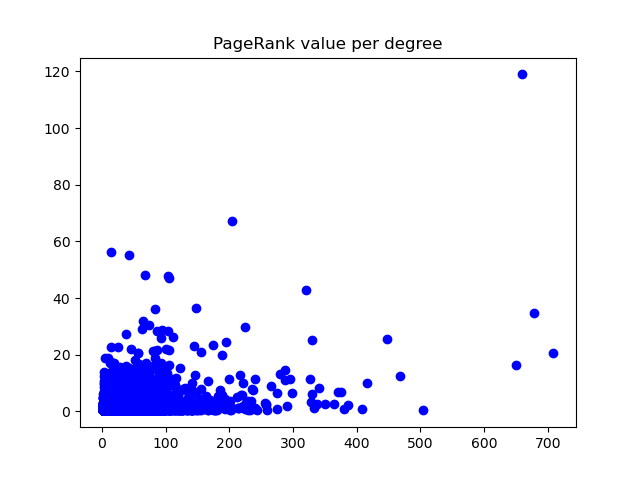

In [104]:
%%python
from tempfile import NamedTemporaryFile
from ast import literal_eval

import matplotlib.pyplot as plt
from IPython.display import Image

with open('degree_pagerank.csv') as file:
    text = file.read()
    
values = literal_eval(text)
# values.sort()

degrees = [degree for degree, pagerank in values]
pagerank = [pagerank for degree, pagerank in values]

plt.clf()
plt.scatter(degrees, pagerank, c="b")
plt.title("PageRank value per degree")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)

## Task 4
Korzystając z Pregel API zaimplementować następujący algorytm. 
- W pierwszym kroku wybrana strona publikuje post fake news. 
- W kolejnym kroku ten post publikowany jest przez ⅓ losowo wybranych kontaktów tej strony. 
- W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane ⅓ jej kontaktów publikuje go u siebie. 

Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków. (2 p.)

In [114]:
import scala.language.implicitConversions

implicit def bool2int(b:Boolean) = if (b) 1 else 0

def makePregel(graph: graphx.Graph[Boolean,String], maxIter: Int): Int = {
    val publishGraph = Pregel(
        graph,
        false,
        maxIter,
        activeDirection = EdgeDirection.Out
    )(
        (id, value, msg) => value || (msg && scala.util.Random.nextFloat() < 0.333),
        triplet => Iterator((triplet.dstId, triplet.srcAttr)),
        (a, b) => a || b
    )
    
    publishGraph.vertices.collect().map(v => v._2 * 1).sum
}

import scala.language.implicitConversions
bool2int: (b: Boolean)Int
makePregel: (graph: org.apache.spark.graphx.Graph[Boolean,String], maxIter: Int)Int


In [116]:
val publishId = 1
val initialGraph = ((publishId: VertexId) => graph.mapVertices((id, _) => id == publishId))(publishId)

val publisherNumbers = for (maxIter <- 1 to 16) yield makePregel(initialGraph, maxIter)

publishId: Int = 1
initialGraph: org.apache.spark.graphx.Graph[Boolean,String] = org.apache.spark.graphx.impl.GraphImpl@1a1c19a3
publisherNumbers: scala.collection.immutable.IndexedSeq[Int] = Vector(12, 128, 410, 740, 1396, 2339, 2837, 3705, 1974, 5438, 5119, 6009, 6824, 5759, 5720, 7634)


In [127]:
val publishId = 19743
val initialGraph = ((publishId: VertexId) => graph.mapVertices((id, _) => id == publishId))(publishId)

val publisherNumbers = for (maxIter <- 1 to 16) yield makePregel(initialGraph, maxIter)

publishId: Int = 19743
initialGraph: org.apache.spark.graphx.Graph[Boolean,String] = org.apache.spark.graphx.impl.GraphImpl@752e3331
publisherNumbers: scala.collection.immutable.IndexedSeq[Int] = Vector(25, 54, 120, 150, 177, 224, 210, 274, 295, 324, 334, 327, 341, 340, 347, 345)


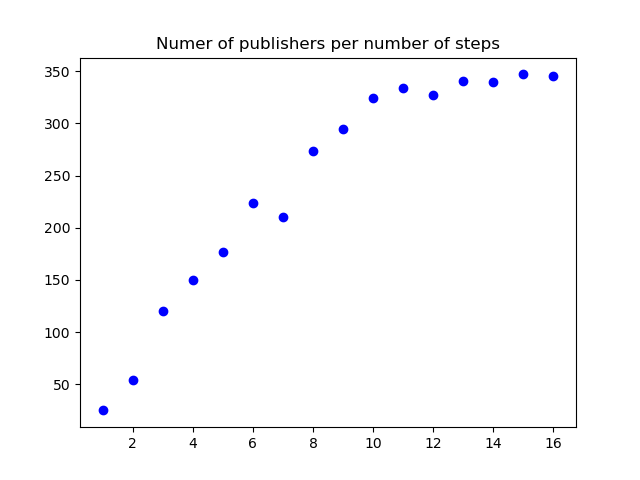

In [128]:
%%python

xs = list(range(1, 17))
ys = [25, 54, 120, 150, 177, 224, 210, 274, 295, 324, 334, 327, 341, 340, 347, 345]

plt.clf()
plt.scatter(xs, ys, c="b")
plt.title("Numer of publishers per number of steps")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)

## Task 5
Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z funkcji obliczającej histogram dla RDD. Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/f/623.pdf  (2 p.)

In [123]:
val degrees = graph.degrees.map(v => v._2)

degrees.takeSample(false, 10)

degrees: org.apache.spark.rdd.RDD[Int] = MapPartitionsRDD[34247] at map at <console>:54
res44: Array[Int] = Array(6, 81, 66, 2, 3, 18, 3, 5, 3, 14)


In [124]:
val (bins, values) = degrees.histogram(degrees.max)

bins: Array[Double] = Array(1.0, 1.998589562764457, 2.997179125528914, 3.9957686882933707, 4.994358251057828, 5.992947813822285, 6.9915373765867415, 7.990126939351199, 8.988716502115656, 9.987306064880112, 10.98589562764457, 11.984485190409027, 12.983074753173483, 13.981664315937941, 14.980253878702397, 15.978843441466855, 16.97743300423131, 17.97602256699577, 18.974612129760224, 19.973201692524682, 20.97179125528914, 21.970380818053595, 22.968970380818053, 23.96755994358251, 24.966149506346966, 25.964739069111424, 26.963328631875882, 27.96191819464034, 28.960507757404795, 29.959097320169253, 30.95768688293371, 31.956276445698165, 32.95486600846262, 33.95345557122708, 34.95204513399154, 35.950634696756, 36.94922425952045, 37.94781382228491, 38.946403385049365, 39.94499294781382, 40.9435...


In [125]:
import java.io._

val file = "histogram_values.csv"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(values.mkString(","))
writer.close()

import java.io._
file: String = histogram_values.csv
writer: java.io.BufferedWriter = java.io.BufferedWriter@7bbe22ff


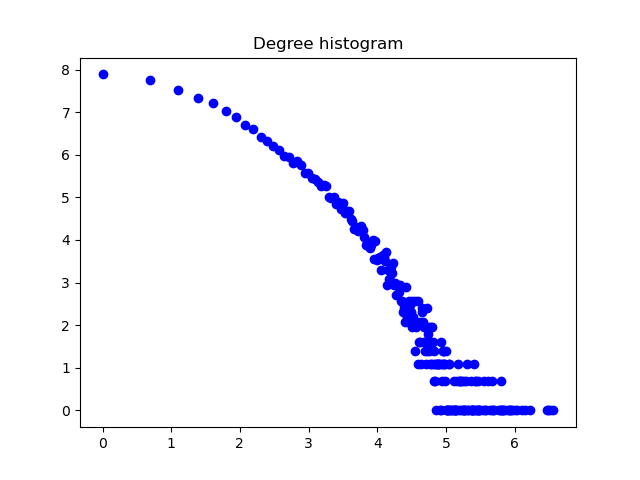

In [126]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

with open("histogram_values.csv") as file:
    text = file.read()

ys = np.array([int(val) for val in text.split(",")])
xs = list(range(1, len(ys) + 1))

plt.clf()
plt.scatter(np.log(xs), np.log(ys), color="b")
plt.title("Degree histogram")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)

Sieć jest bezskalowa.